# setting

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# lettura dataset

In [6]:
df = pd.read_csv("data/framingham.csv")
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


# esplorazione

In [7]:
df.shape

(4238, 16)

In [8]:
df.dtypes

male                 int64
age                  int64
education          float64
currentSmoker        int64
cigsPerDay         float64
BPMeds             float64
prevalentStroke      int64
prevalentHyp         int64
diabetes             int64
totChol            float64
sysBP              float64
diaBP              float64
BMI                float64
heartRate          float64
glucose            float64
TenYearCHD           int64
dtype: object

In [9]:
df.describe(include='all')

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,4238.000000,4238.000000,4133.000000,4238.000000,4209.000000,4185.000000,4238.000000,4238.000000,4238.000000,4188.000000,4238.000000,4238.000000,4219.000000,4237.000000,3850.000000,4238.000000
mean,0.429212,49.584946,1.978950,0.494101,9.003089,0.029630,0.005899,0.310524,0.025720,236.721585,132.352407,82.893464,25.802008,75.878924,81.966753,0.151958
std,0.495022,8.572160,1.019791,0.500024,11.920094,0.169584,0.076587,0.462763,0.158316,44.590334,22.038097,11.910850,4.080111,12.026596,23.959998,0.359023
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.070000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.400000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,144.000000,89.875000,28.040000,83.000000,87.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


In [10]:
sum(df.duplicated())

# non ci sono duplicati

0

In [11]:
df.isnull().sum()

# ci sono diversi missing values

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

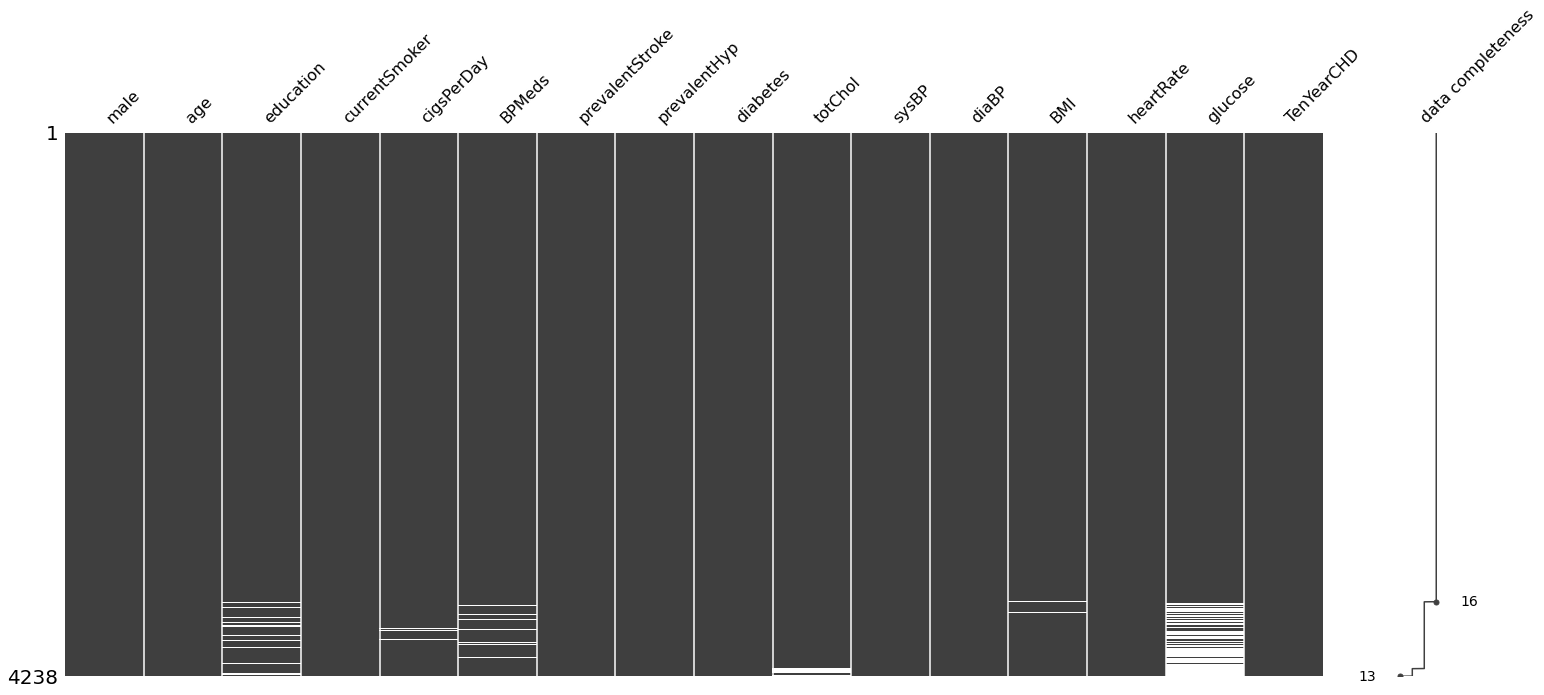

In [12]:
import missingno as msno

msno.matrix(df, labels=True, sort="descending");

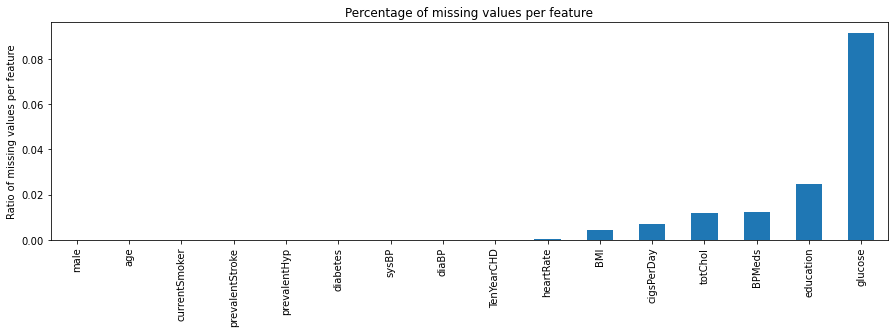

In [13]:
df.isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4),
    title="Percentage of missing values per feature",
    ylabel="Ratio of missing values per feature");

# la maggior parte dei misssing values sono per la variabile glucose

In [14]:
df.isnull().sum().sum()/len(df)  # rivedere meglio

0.15219443133553562

In [15]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})

missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df

,column_name,percent_missing
male,male,0.000000
age,age,0.000000
currentSmoker,currentSmoker,0.000000
prevalentStroke,prevalentStroke,0.000000
prevalentHyp,prevalentHyp,0.000000
diabetes,diabetes,0.000000
sysBP,sysBP,0.000000
diaBP,diaBP,0.000000
TenYearCHD,TenYearCHD,0.000000
heartRate,heartRate,0.023596


In [16]:
df[df.isna().any(axis=1)]


# I understand that most of the variables with missing numbers are related to medical records and it is better not to impute this type of information.

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
14,0,39,2.0,1,9.0,0.0,0,0,0,226.0,114.0,64.0,22.35,85.0,NaN,0
21,0,43,1.0,0,0.0,0.0,0,0,0,185.0,123.5,77.5,29.89,70.0,NaN,0
26,0,60,1.0,0,0.0,0.0,0,0,0,260.0,110.0,72.5,26.59,65.0,NaN,0
33,1,61,NaN,1,5.0,0.0,0,0,0,175.0,134.0,82.5,18.59,72.0,75.0,1
36,1,56,NaN,0,0.0,0.0,0,0,0,257.0,153.5,102.0,28.09,72.0,75.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4208,0,51,1.0,1,9.0,0.0,0,0,0,340.0,152.0,76.0,25.74,70.0,NaN,0
4229,0,51,3.0,1,20.0,0.0,0,1,0,251.0,140.0,80.0,25.60,75.0,NaN,0
4230,0,56,1.0,1,3.0,0.0,0,1,0,268.0,170.0,102.0,22.89,57.0,NaN,0
4235,0,48,2.0,1,20.0,NaN,0,0,0,248.0,131.0,72.0,22.00,84.0,86.0,0


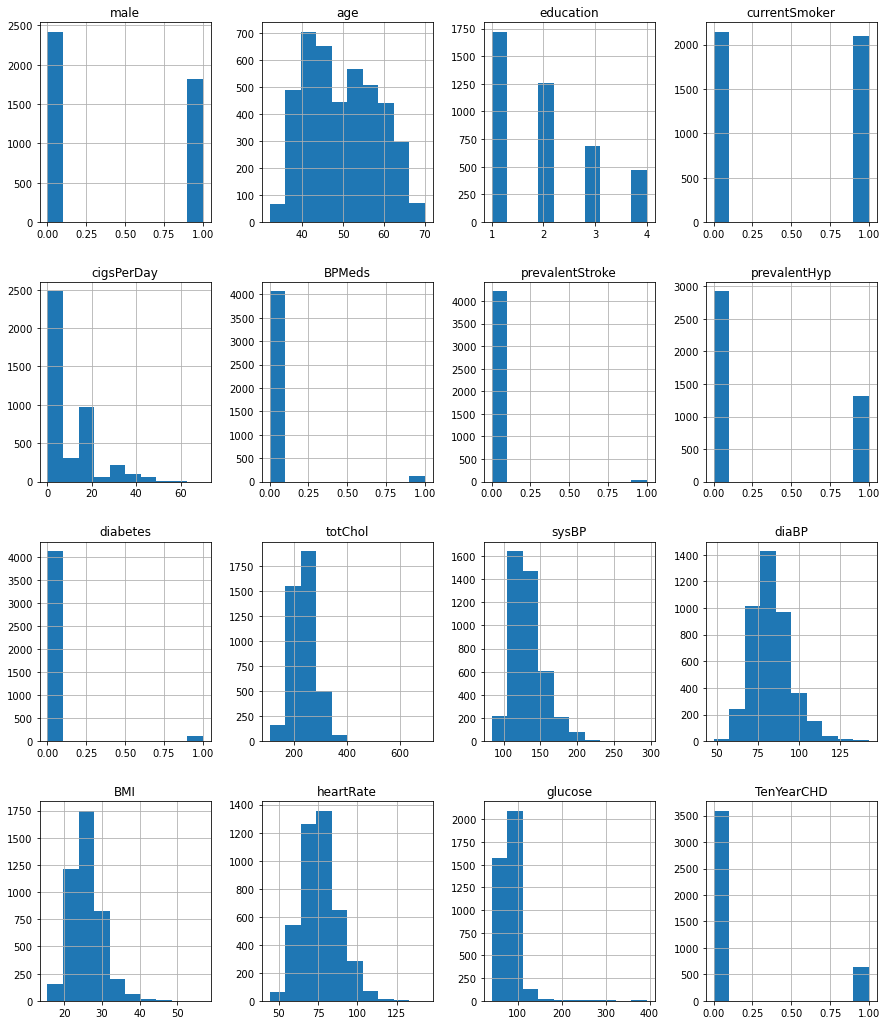

In [17]:
df.hist(figsize=(15,18))
plt.show()

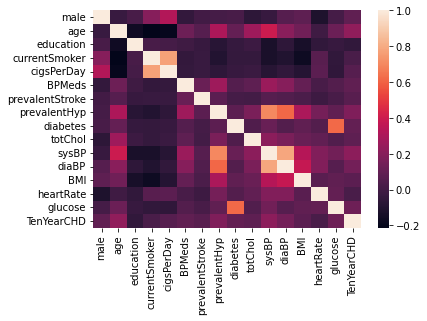

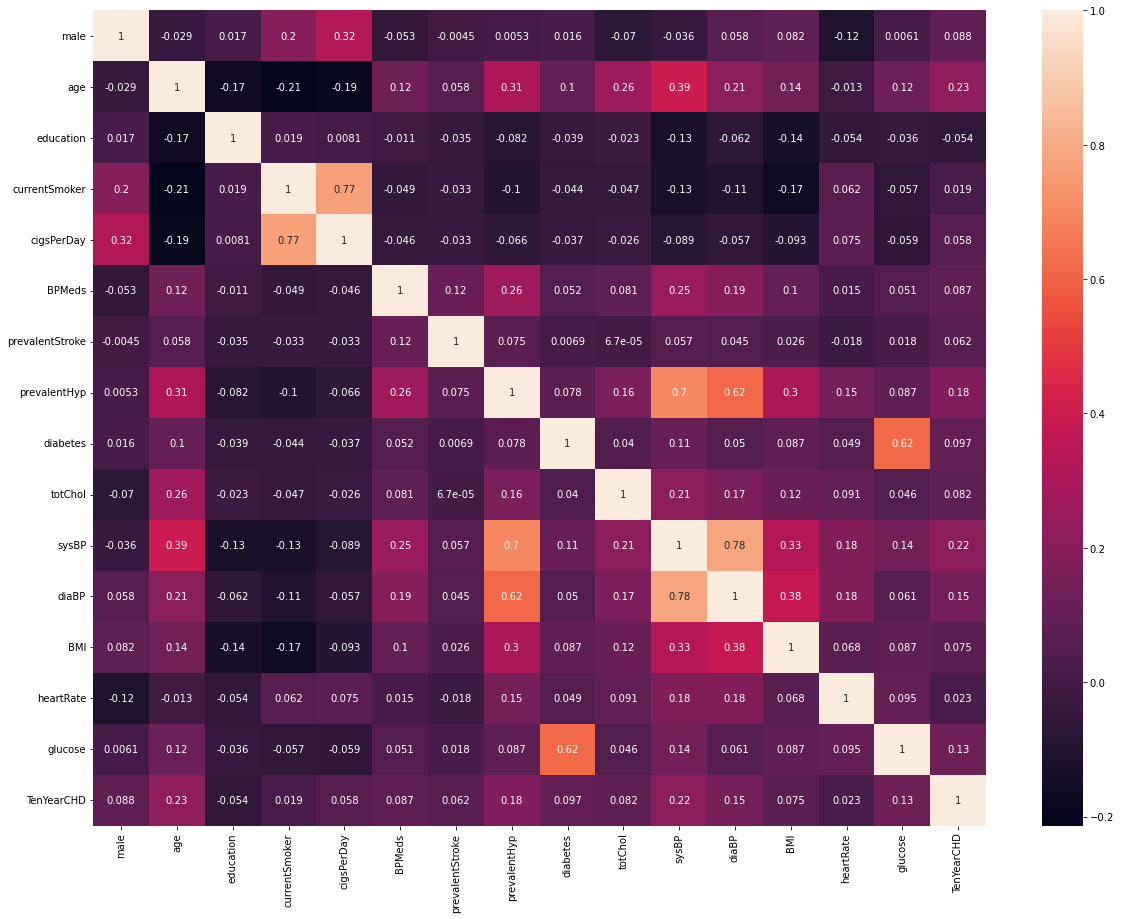

In [18]:
# Calcolo della correlazione
df.corr()


# Visualizzazione della correlazione
sns.heatmap(df.corr())

f, ax = plt.subplots(figsize=(20,15))

sns.heatmap(df.corr(), annot=True);

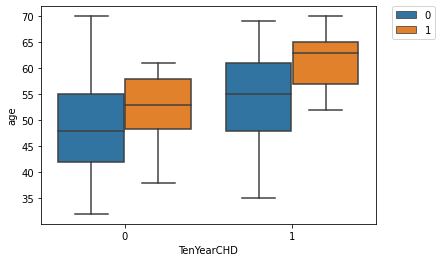

In [19]:
sns.boxplot(x='TenYearCHD',y='age',hue='prevalentStroke',data=df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# e simili
# https://medium.com/swlh/the-framingham-heart-study-decision-trees-83a7fb62718e

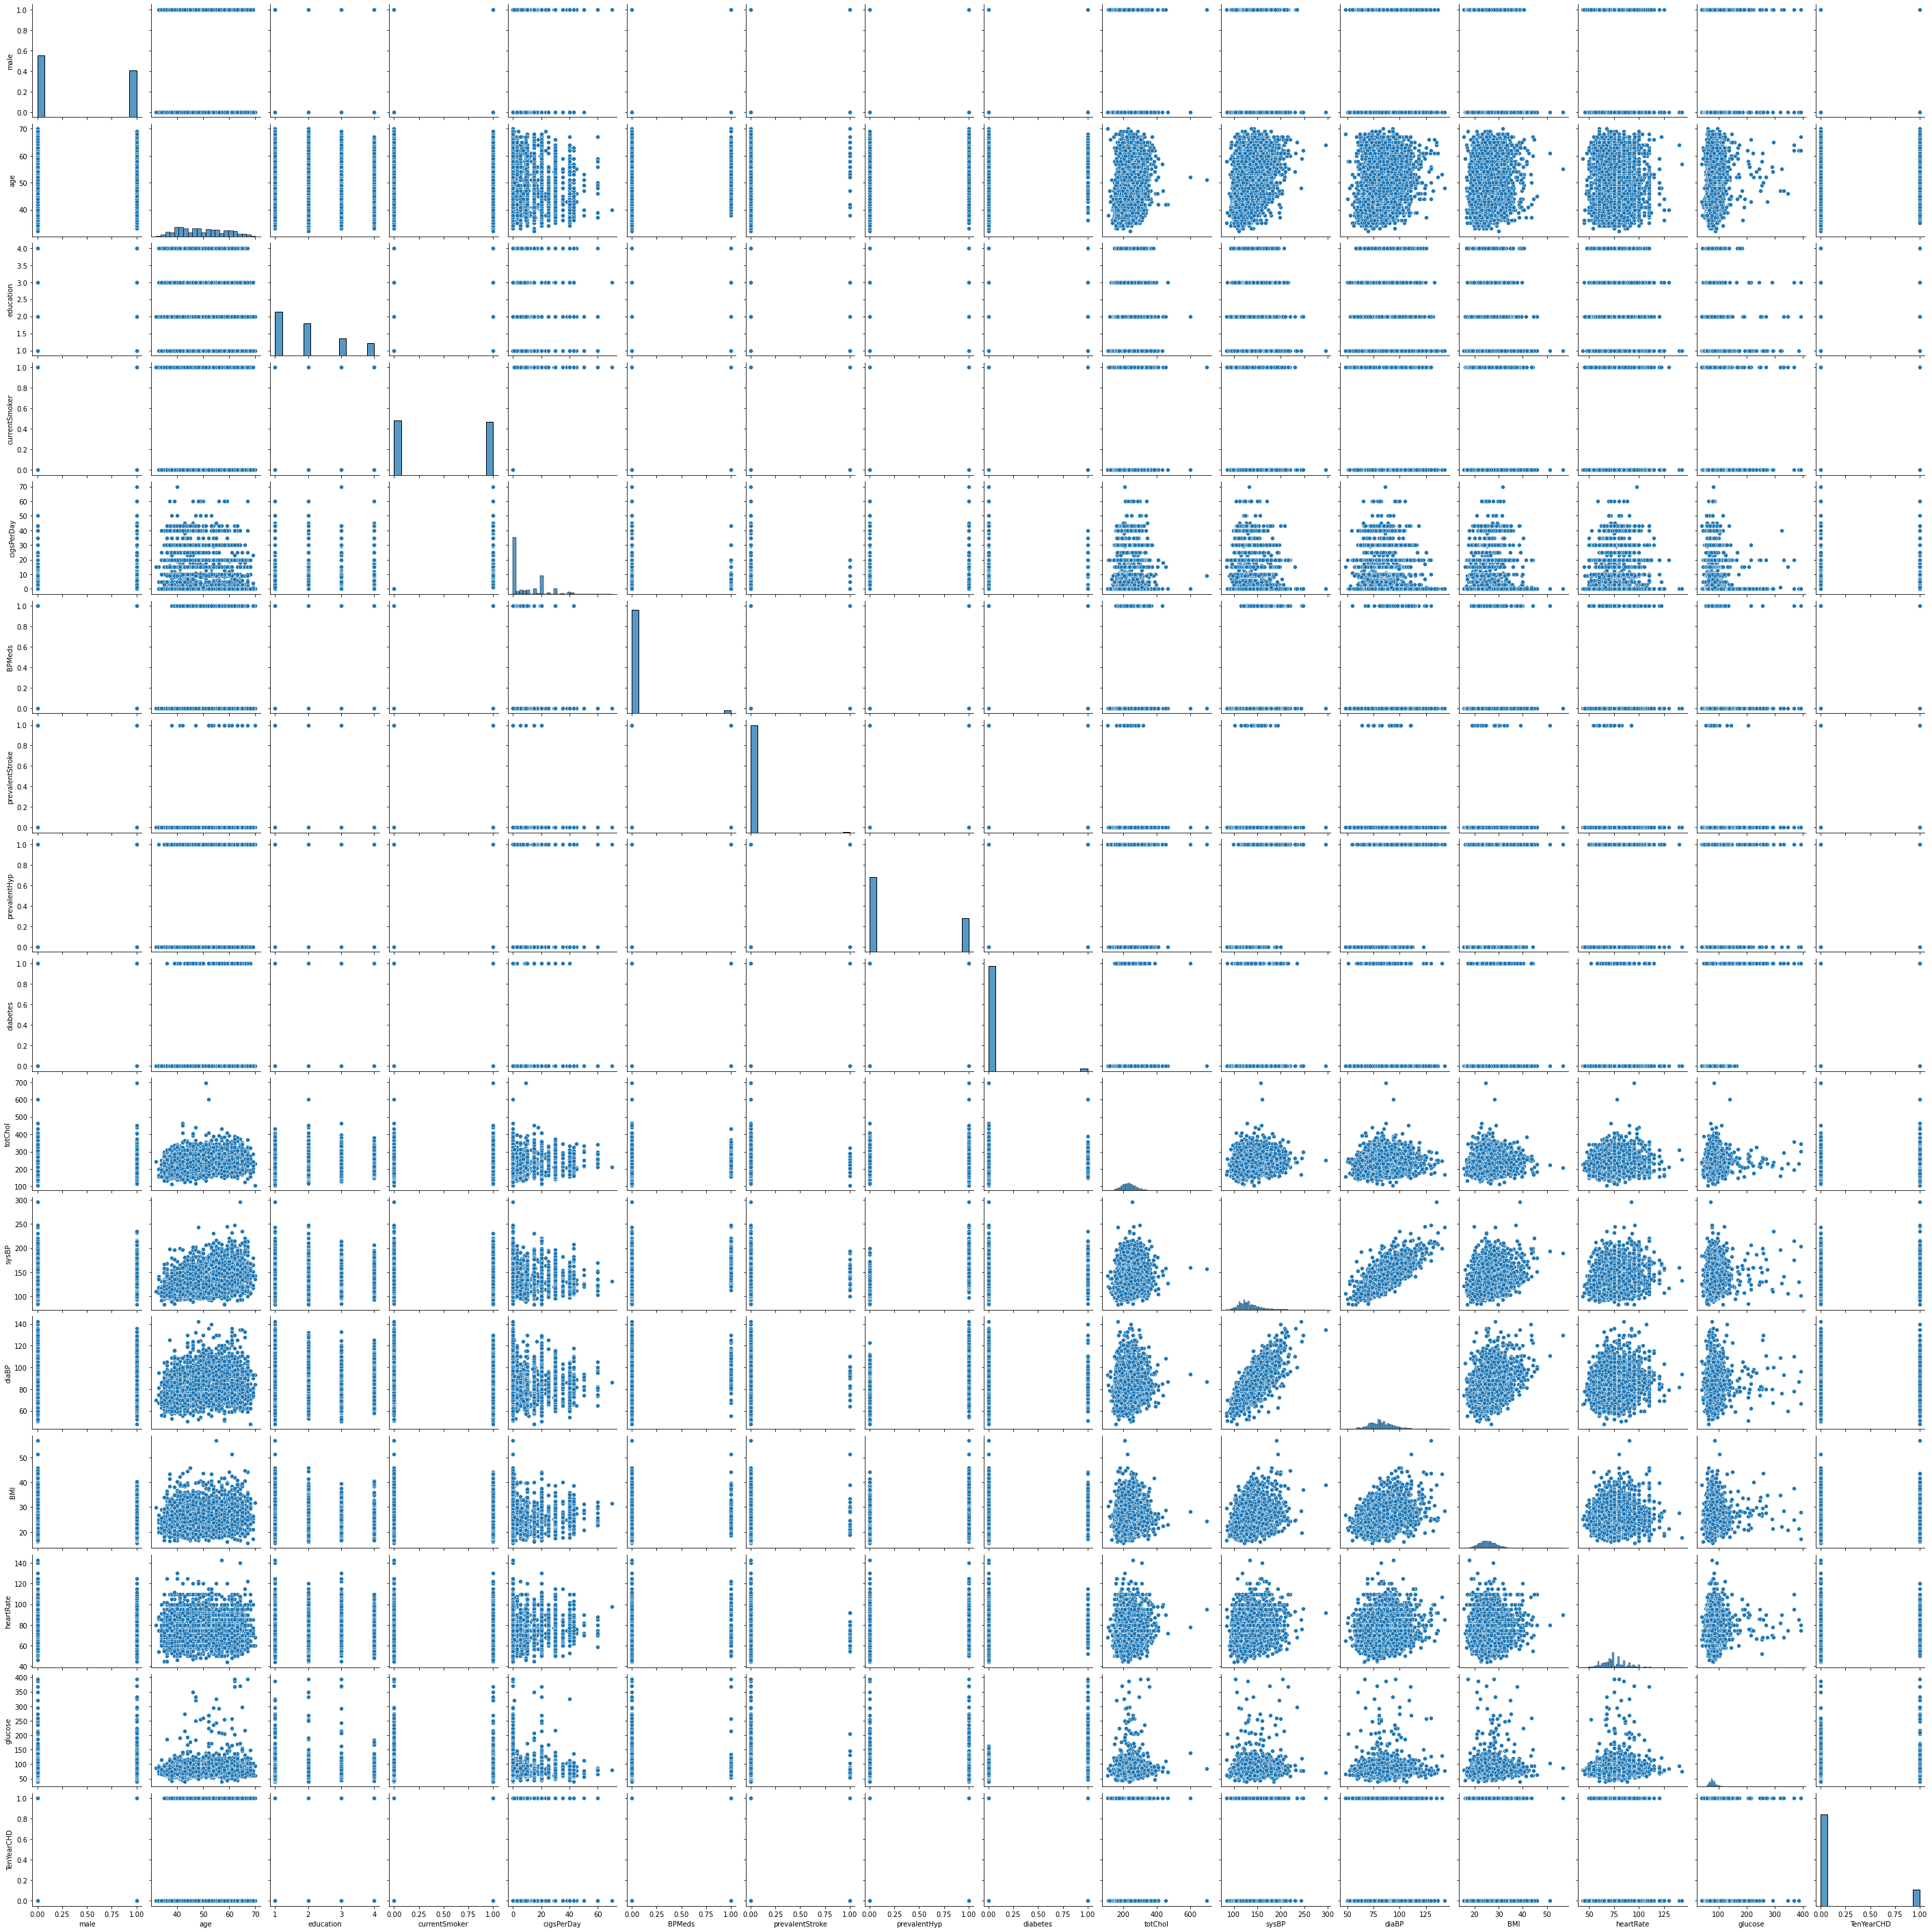

In [20]:
# Checking for outliers
df.describe()
sns.pairplot(df)

# pre processing

## gestione feature

In [ ]:
# creazione/eliminazione di feature

# We are dropping the column education because a doctor would have to decide on which education level to put a patient and this could result in very subjective outcomes and it is also not very handy to put in practice.

# decido di tenerlo

In [ ]:
# rendere variabili categoriche

In [ ]:
# rendere dummies alcune variabili categoriche

In [ ]:
# standardizzare

## gestione missing values

In [31]:
# Dropping all rows with missing data

# As all the variables with missing values have less than 25% of missing information, it will not be considered deleting the whole column but only the rows that contain missing information. I understand that most of the variables with missing numbers are related to medical records and it is better not to impute this type of information.

df_clean = df.dropna()
df_clean.isna().sum()

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

## divisione train test

 capire se fare prima o dopo class imbalance

In [122]:
from sklearn.model_selection import train_test_split

# clarify what is y and what is x label
y = df_clean['TenYearCHD']
X = df_clean.drop(['TenYearCHD'], axis = 1)

# divide train test: 80 % - 20 %
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=29)

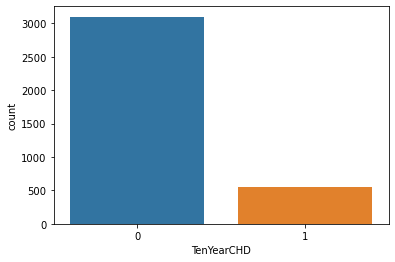

In [123]:
ax = sns.countplot(x=y)

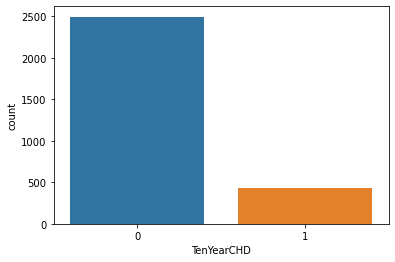

In [124]:
ax = sns.countplot(x=y_train)

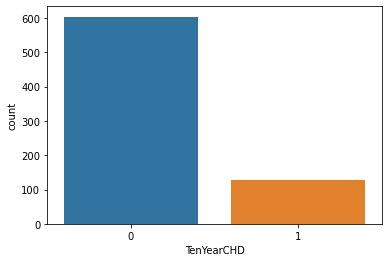

In [125]:
ax = sns.countplot(x=y_test)

## gestione class imbalance

Class 0: 3099
Class 1: 557
Proportion: 5.56 : 1


/Users/lorenzolorgna/.conda/envs/fisica/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


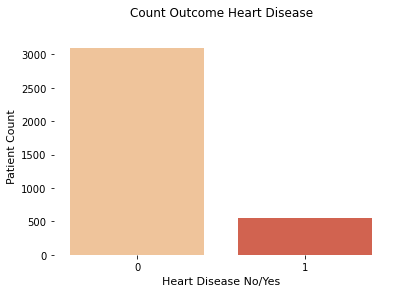

In [126]:
# Checking balance of outcome variable
target_count = df_clean.TenYearCHD.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

sns.countplot(df_clean.TenYearCHD, palette="OrRd")
plt.box(False)
plt.xlabel('Heart Disease No/Yes',fontsize=11)
plt.ylabel('Patient Count',fontsize=11)
plt.title('Count Outcome Heart Disease\n')
plt.savefig('Balance Heart Disease.png')
plt.show()

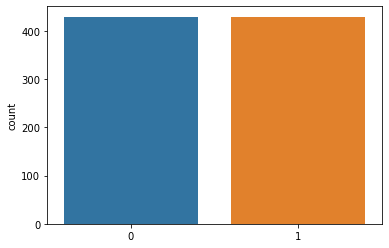

In [127]:
# The easiest way to do so is to randomly select observations from the majority class and remove them from the data set until we achieve a balance between the majority and minority class. -> UNDERSAMPLING

# Undersampling can be defined as removing some observations of the majority class. This is done until the majority and minority class is balanced out.
# Undersampling can be a good choice when you have a ton of data -think millions of rows. But a drawback to undersampling is that we are removing information that may be valuable.

# A number of more sophisticated resampling techniques have been proposed in the scientific literature.
# Let’s apply some of these resampling techniques, using the Python library imbalanced-learn. It is compatible with scikit-learn and is part of scikit-learn-contrib projects.

# alcune tecnicnhe:
# RandomUnderSampler is a fast and easy way to balance the data by randomly selecting a subset of data for the targeted classes. Under-sample the majority class(es) by randomly picking samples with or without replacement.

# NearMiss is an under-sampling technique. Instead of resampling the Minority class, using a distance, this will make the majority class equal to the minority class.


# https://hersanyagci.medium.com/under-sampling-methods-for-imbalanced-data-clustercentroids-randomundersampler-nearmiss-eae0eadcc145
# da fare solo sul train
from imblearn.under_sampling import NearMiss
nr = NearMiss(version=3)
X_train_miss, y_train_miss = nr.fit_sample(X_train, y_train.ravel())  # mentre il test non lo tocco, ora X_train_miss e y_train_miss sono i miei nuovi Train
ax = sns.countplot(x=y_train_miss)
X_train_miss = pd.DataFrame(X_train_miss)
y_train_miss = pd.DataFrame(y_train_miss)
y_train_miss.rename(columns={0: 'TenYearCHD'}, inplace=True)

In [128]:
# train: X_train_miss, y_train_miss è stato ribilanciato
# test: X_test, y_test è rimasto così

In [129]:
X_train_miss.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,0,62,1.0,0,0.0,0.0,0,0,1,233.0,130.0,87.0,21.34,85.0,386.0
1,0,50,1.0,0,0.0,0.0,0,1,1,260.0,190.0,130.0,43.67,85.0,260.0
2,0,54,1.0,0,0.0,0.0,0,1,1,326.0,187.0,95.0,29.94,67.0,235.0
3,0,46,2.0,1,15.0,0.0,0,0,1,233.0,106.0,60.0,20.84,75.0,348.0
4,1,52,1.0,0,0.0,0.0,0,1,1,178.0,160.0,98.0,40.11,75.0,225.0


In [130]:
y_train_miss

,TenYearCHD
0,0
1,0
2,0
3,0
4,0
...,...
853,1
854,1
855,1
856,1


In [131]:
X_test.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
4194,1,65,1.0,1,20.0,1.0,0,1,0,246.0,179.0,96.0,19.34,95.0,76.0
3845,1,40,3.0,1,30.0,0.0,0,0,0,190.0,110.0,70.0,24.63,60.0,72.0
2602,0,60,2.0,0,0.0,0.0,0,0,0,354.0,130.0,82.5,26.76,65.0,79.0
2732,0,40,2.0,1,15.0,0.0,0,1,0,232.0,140.0,92.0,26.56,75.0,73.0
1178,1,45,1.0,1,15.0,0.0,0,0,0,221.0,131.0,84.0,28.58,85.0,72.0


In [132]:
y_test.head()

4194    1
3845    0
2602    0
2732    0
1178    0
Name: TenYearCHD, dtype: int64

# decision tree per individuare i fattori di rischio delle malattie cardiache più rilevanti (+ disegno)

In [133]:
# https://towardsdatascience.com/the-5-feature-selection-algorithms-every-data-scientist-need-to-know-3a6b566efd2

In [134]:
# https://towardsdatascience.com/why-how-and-when-to-apply-feature-selection-e9c69adfabf2
# Embedded Methods

# Feature selection can also be acheived by the insights provided by some Machine Learning models.

# Tree based models calculates feature importance for they need to keep the best performing features as close to the root of the tree. Constructing a decision tree involves calculating the best predictive feature.

In [135]:
# test 1

# embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
# embeded_rf_selector.fit(X, y)
#
# embeded_rf_support = embeded_rf_selector.get_support()
# embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
# print(str(len(embeded_rf_feature)), 'selected features')
# embeded_rf_feature

In [136]:
# test 2
# https://www.youtube.com/watch?v=7v4Qdm5v9aA

High-Dimensionality Score: 0.8237704918032787


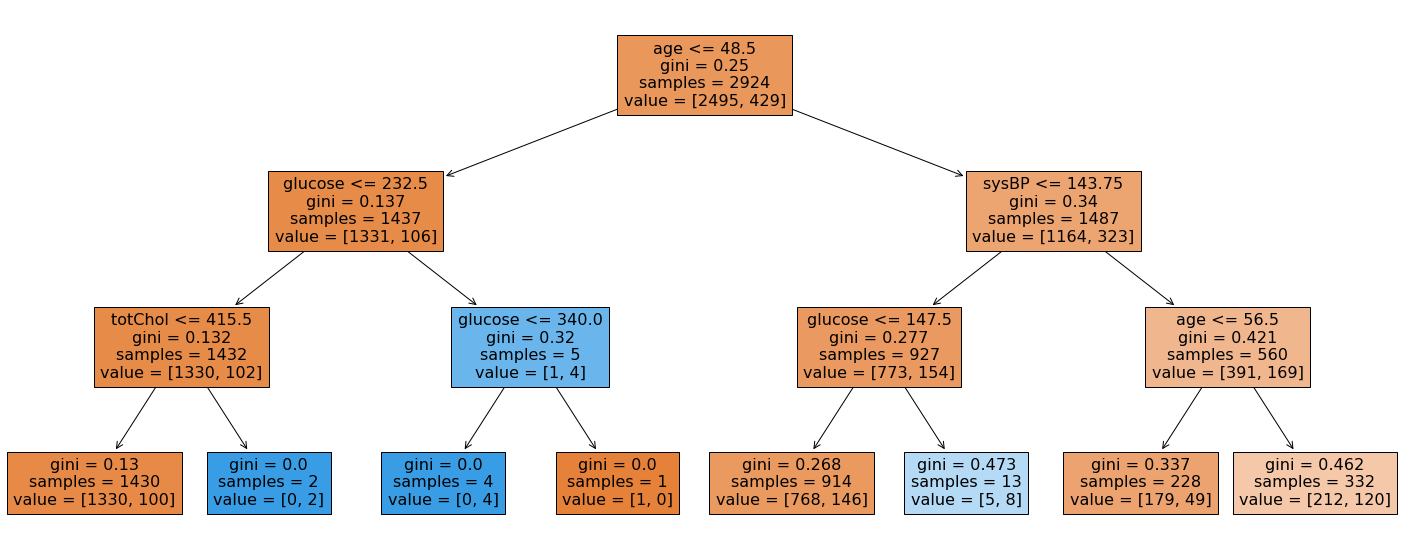

/Users/lorenzolorgna/.conda/envs/fisica/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


CalledProcessError: Command '['dot', '-Tsvg', '-o', '/var/folders/4l/l5t6x01s767d0kxm07k6dpww0000gn/T/DTreeViz_97104.svg', '/var/folders/4l/l5t6x01s767d0kxm07k6dpww0000gn/T/DTreeViz_97104']' died with <Signals.SIGKILL: 9>. [stderr: b'']

In [144]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from dtreeviz.trees import dtreeviz

dct = DecisionTreeClassifier(max_depth=3)
dct.fit(X_train, y_train)
score = dct.score(X_test, y_test)
print("High-Dimensionality Score:", score)



fig = plt.figure(figsize=(25,10))
_ = tree.plot_tree(dct,
                   feature_names=X.columns,
                   filled=True)
plt.show()

In [ ]:
viz = dtreeviz(dct, X, y['TenYearCHD'],
               target_name='TenYearCHD',
               feature_names=list(X.columns))

viz

# eventualmente posso provarea cnhe boosted decision tree

In [ ]:
# da lezioni

import xgboost as xgb

feature_names = data.columns[1:-2]  # we skip the first and last two columns because they are the ID, weight, and label

train = xgb.DMatrix(data=data_train[feature_names],
                    label=data_train.Label.cat.codes,
                    missing=-999.0,
                    feature_names=feature_names)

test = xgb.DMatrix(data=data_test[feature_names],
                   label=data_test.Label.cat.codes,
                   missing=-999.0,
                   feature_names=feature_names)

param = {}

# Booster parameters
param['eta']              = 0.1 # learning rate
param['max_depth']        = 10  # maximum depth of a tree
param['subsample']        = 0.8 # fraction of events to train tree on
param['colsample_bytree'] = 0.8 # fraction of features to train tree on

# Learning task parameters
param['objective']   = 'binary:logistic' # objective function
param['eval_metric'] = 'error'           # evaluation metric for cross validation
param = list(param.items()) + [('eval_metric', 'logloss')] + [('eval_metric', 'rmse')]

num_trees = 100  # number of trees to make


booster = xgb.train(param, train, num_boost_round=num_trees)

predictions = booster.predict(test)

# plot all predictions (both signal and background)
plt.hist(predictions, bins=np.linspace(0,1,50), histtype='step', color='darkgreen', label='All events')

plt.xlabel('Prediction from BDT', fontsize=12)
plt.ylabel('Events', fontsize=12)
plt.legend(frameon=False)
plt.show()

# plot signal and background separately
plt.hist(predictions[test.get_label().astype(bool)], bins=np.linspace(0,1,50),
         histtype='step', color='midnightblue', label='signal')
plt.hist(predictions[~(test.get_label().astype(bool))], bins=np.linspace(0,1,50),
         histtype='step', color='firebrick', label='background')

plt.xlabel('Prediction from BDT',fontsize=12)
plt.ylabel('Events',fontsize=12)
plt.legend(frameon=False)
plt.show()

xgb.plot_importance(booster, grid=False);
plt

d = data_train.copy()

d['prediction'] = np.around(booster.predict(train)).astype('int64')
d['prediction'] = d['prediction'].map({1: 's', 0: 'b'})

d[['prediction', 'Label']]

right = d.loc[d['prediction'] == d['Label']]
wrong = d.loc[d['prediction'] != d['Label']]

true_positive = right.loc[right['prediction'] == 's']
false_positive = wrong.loc[wrong['prediction'] == 's']
false_negative = wrong.loc[wrong['prediction'] == 'b']

print("We had %d elements in our recordset." % len(d))
print("We classified correctly %d events." % len(right))
print("We classified wrongly %d events." % len(wrong))
print("We had %d false positive and %d false negative." % (len(false_positive), len(false_negative)))

print("")

print("Our precision has been %1.2f." % (len(true_positive)/(len(true_positive) + len(false_positive))))
print("Our recall has been %1.2f." % (len(true_positive)/(len(true_positive) + len(false_negative))))


# vedi anche notebook lab soluzioni

In [ ]:
# una volta selezionate variabili importanti fare un minimo di esplorazione, tipo scatterplot correlazione

# da questi risultati seleziono le variabili più importanti che deiventano input della logistic regression nel passo successivo

In [ ]:
# creo nuovo df solo con variabili imp
#Creating a dataset with only the features selected
data_features = df_clean.drop(['glucose', 'sysBP'], axis=1)
data_features.head()



# Apart from decision tree and random forest classifiers the other classifiers that will be tested require scaled data.
# per la logistic regression è necessario fare scaling

# da industry lab
# scaler = StandardScaler()
#
# numerical_features = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width']
#
# df_train_prep = pd.DataFrame(
#     scaler.fit_transform(df_train[numerical_features]),
#     columns=numerical_features,
#     index=df_train.index
# )
#
# df_train_prep = pd.concat([df_train_prep, df_train['class']], axis=1)
#
# df_train_prep.head()








# train e test


In [ ]:
# regressione logistica per prevedere il rischio complessivo

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression


normalized_df_reg = LogisticRegression().fit(X_train, y_train)

normalized_df_reg_pred = normalized_df_reg.predict(X_test)





# check accuracy: Accuracy: Overall, how often is the classifier correct? Accuracy = (True Pos + True Negative)/total
acc = accuracy_score(y_test, normalized_df_reg_pred)
print(f"The accuracy score for LogReg is: {round(acc,3)*100}%")

# f1 score: The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.
f1 = f1_score(y_test, normalized_df_reg_pred)
print(f"The f1 score for LogReg is: {round(f1,3)*100}%")

# Precision score: When it predicts yes, how often is it correct? Precision=True Positive/predicted yes
precision = precision_score(y_test, normalized_df_reg_pred)
print(f"The precision score for LogReg is: {round(precision,3)*100}%")

# recall score: True Positive Rate(Sensitivity or Recall): When it’s actually yes, how often does it predict yes? True Positive Rate = True Positive/actual yes
recall = recall_score(y_test, normalized_df_reg_pred)
print(f"The recall score for LogReg is: {round(recall,3)*100}%")

D:\Anaconda\envs\env_fisica\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The accuracy score for LogReg is: 83.2%
The f1 score for LogReg is: 16.400000000000002%
The precision score for LogReg is: 31.8%
The recall score for LogReg is: 11.1%


D:\Anaconda\envs\env_fisica\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Text(0.5, 1.1, 'Confusion matrix Logistic Regression\n')

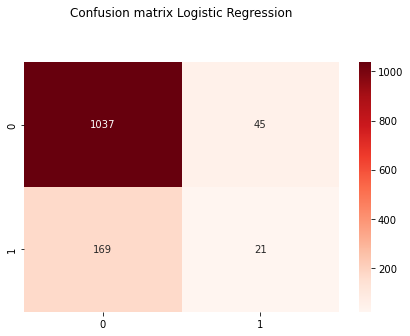

In [30]:
# plotting confusion matrix LogReg

cnf_matrix_log = confusion_matrix(y_test, normalized_df_reg_pred)

sns.heatmap(pd.DataFrame(cnf_matrix_log), annot=True,cmap="Reds" , fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix Logistic Regression\n', y=1.1)